# Calculation of perception uncertainty ground truth

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter

import matplotlib.pyplot as plt
import operator

## Preprocess original file to remove quotations

In [17]:
filePath = './data/jointly_annotated.csv'
df = pd.read_csv(filePath, sep='|', quotechar="'")

In [18]:
df.tail()

,Author_ID,Author_name,Comment_number,Sentence_number,Domain_Relevance,Sentiment,Entity,Attribute,Sentence,Source_file,Annotator
3722,Joshua-Engel,Joshua Engel,507,1,0,NaN,NaN,NaN,"Yeah, it's definitely complicated.",quora.json,hannah
3723,Joshua-Engel,Joshua Engel,507,2,0,NaN,NaN,NaN,I'm not a big fan of the monocultures for exac...,quora.json,hannah
3724,"""Joshua-Engel",Joshua Engel,507,3,9,n,f,g,"""""Commercial """"""""organic"""""""" is deeply problem...",quora.json,"hannah"""
3725,"""Joshua-Engel",Joshua Engel,507,3,9,p,f,g,"""""Commercial """"""""organic"""""""" is deeply problem...",quora.json,"hannah"""
3726,Jack-Willis-9,Jack Willis,510,1,9,0,p,p,If there is a considerable decrease in input c...,quora.json,hannah


In [20]:
df.Annotator.value_counts()

hannah        431
kamal         356
abhilasha     356
sebastian     335
sumit         325
sarthak       323
felix         318
omar          318
fahad         305
florian       299
hannah"        51
sebastian"     42
kamal"         42
felix"         42
sumit"         42
omar"          37
fahad"         35
florian"       34
abhilasha"     26
sarthak"       10
Name: Annotator, dtype: int64

In [21]:
df['Annotator'] = df['Annotator'].apply(lambda x: x.replace('"', ''))

In [23]:
df.Annotator.value_counts()

hannah       482
kamal        398
abhilasha    382
sebastian    377
sumit        367
felix        360
omar         355
fahad        340
sarthak      333
florian      333
Name: Annotator, dtype: int64

In [24]:
df.Author_ID.value_counts()

Rahul-Shankar            486
Joshua-Engel             366
John-DuRette             224
Jamie-Lynn-Morgan        215
Bryceton-Bible           185
Patrick-Daly-34          184
Jim-Seidman              173
Ravi-Nagori-1            166
Matan-Shelomi            132
Prasanna-Kumar-T-S-M     128
Rochelle-Foster          128
Josephine-Gibbs          125
Eric-Guicherit           111
"Joshua-Engel            108
Matthew-Petrucci          93
Michael-Graham-4          81
Andrew-Brodsky-1          78
Jim-Gordon                68
Merredith-Branscombe      63
Mark-Horn                 61
John-Jeffrey-Mardlin      55
Mark-Keating              45
"Dallas-Herrmann          45
Scott-Strough             43
Nate-Berg-1               39
"Rahul-Shankar            36
Stephen-R-Morse           33
Dallas-Herrmann           32
"Jim-Seidman              32
Mikka-Luster              30
"Michael-Graham-4         20
"John-DuRette             19
"Matan-Shelomi            19
Danise-Codekas            12
"Katy-Cavaller

In [25]:
df['Author_ID'] = df['Author_ID'].apply(lambda x: x.replace('"', ''))

In [26]:
df.Author_ID.value_counts()

Rahul-Shankar           522
Joshua-Engel            474
John-DuRette            243
Jamie-Lynn-Morgan       223
Jim-Seidman             205
Bryceton-Bible          194
Patrick-Daly-34         184
Ravi-Nagori-1           174
Matan-Shelomi           151
Prasanna-Kumar-T-S-M    128
Rochelle-Foster         128
Josephine-Gibbs         125
Eric-Guicherit          111
Michael-Graham-4        101
Matthew-Petrucci         93
Andrew-Brodsky-1         88
Dallas-Herrmann          77
Merredith-Branscombe     72
Mark-Horn                70
Jim-Gordon               68
John-Jeffrey-Mardlin     55
Mark-Keating             54
Scott-Strough            43
Nate-Berg-1              39
Stephen-R-Morse          33
Mikka-Luster             30
Danise-Codekas           12
Katy-Cavallero           11
Jack-Willis-9            10
Chris-Loughnane           9
Name: Author_ID, dtype: int64

In [27]:
filePath = './data/jointly_annotated_processed.csv'
df.to_csv(filePath, sep='|', encoding='utf-8',index=False)

## Load the preprocessed file

In [2]:
def plot_annotation_count(df):
    annotation_counts = df.groupby(['Comment_number','Sentence_number'])['Author_ID'].agg('count').value_counts()
    plt.bar(annotation_counts.keys(), annotation_counts.values)
    plt.xlabel('Number of annotations per sample')
    plt.ylabel('Samples with X many annotations per sample')
    plt.title('Per sample annotation counts')
    plt.show()

In [3]:
filePath = './data/jointly_annotated_processed.csv'
df = pd.read_csv(filePath, sep='|')

In [4]:
df.head()

,Author_ID,Author_name,Comment_number,Sentence_number,Domain_Relevance,Sentiment,Entity,Attribute,Sentence,Source_file,Annotator
0,Matthew-Petrucci,Matthew Petrucci,414,9,9,0,f,h,Consider that there are myriad varieties of na...,quora.json,fahad
1,Matthew-Petrucci,Matthew Petrucci,414,10,9,0,cf,c,Most supermarket/greengrocer tomatoes are grow...,quora.json,fahad
2,Matthew-Petrucci,Matthew Petrucci,414,11,0,NaN,NaN,NaN,These facilities are regularly sprayed and con...,quora.json,fahad
3,Matthew-Petrucci,Matthew Petrucci,414,12,9,0,cp,h,Especially in the U.S. tomatoes (among other f...,quora.json,fahad
4,Matthew-Petrucci,Matthew Petrucci,414,13,9,0,p,h,"Remember, you are paying a premium for organic...",quora.json,fahad


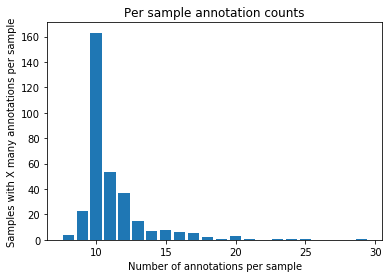

In [5]:
plot_annotation_count(df)

In [6]:
df = df[df.Domain_Relevance==9]

## Add columns based on coarse and fine properties

In [7]:
sentiments = ['p', 'n', '0']

entities_fine = ['g', 'p', 'f', 'c', 'cg', 'cp', 'cf', 'cc', 'gg']
attributes_fine = ['g', 'p', 't', 'q', 's', 'h', 'c', 'll', 'or', 'l', 'av', 'e', 'a', 'pp']
triplets_fine = [e+'-'+a+'-'+s for e in entities_fine for a in attributes_fine for s in sentiments]

entities_coarse = ['organic', 'conventional', 'GMO']
attributes_coarse = ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources', 'environment']
triplets_coarse = [e+'-'+a+'-'+s for e in entities_coarse for a in attributes_coarse for s in sentiments]


od_coarse_entities = {
	'g': 'organic',
	'p': 'organic',
	'f': 'organic',
	'c': 'organic',
	'cg': 'conventional',
	'cp': 'conventional',
	'cf': 'conventional',
	'cc': 'conventional',
	'gg': 'GMO'
}
od_coarse_attributes = {
	'g': 'general',
	'p': 'price',
	't': 'experienced quality',
	'q': 'experienced quality',
	's': 'safety and healthiness',
	'h': 'safety and healthiness',
	'c': 'safety and healthiness',
	'll': 'trustworthy sources',
	'or': 'trustworthy sources',
	'l': 'trustworthy sources',
	'av': 'trustworthy sources',
	'e': 'environment',
	'a': 'environment',
	'pp': 'environment'
}

In [8]:
def returnCoarse(entity,isEntity=True):
    if (isEntity==True):
        return od_coarse_entities[entity]
    else:
        return od_coarse_attributes[entity]

In [9]:
df['Fine_Triplet'] = df['Entity']+'-'+df['Attribute']+'-'+df['Sentiment']

df['Coarse_Entity'] = df.apply(lambda row: returnCoarse(row['Entity']), axis=1)
df['Coarse_Attribute'] = df.apply(lambda row: returnCoarse(row['Attribute'],False), axis=1)
df['Coarse_Triplet'] = df['Coarse_Entity']+'-'+df['Coarse_Attribute']+'-'+df['Sentiment']

In [10]:
df.head()

,Author_ID,Author_name,Comment_number,Sentence_number,Domain_Relevance,Sentiment,Entity,Attribute,Sentence,Source_file,Annotator,Fine_Triplet,Coarse_Entity,Coarse_Attribute,Coarse_Triplet
0,Matthew-Petrucci,Matthew Petrucci,414,9,9,0,f,h,Consider that there are myriad varieties of na...,quora.json,fahad,f-h-0,organic,safety and healthiness,organic-safety and healthiness-0
1,Matthew-Petrucci,Matthew Petrucci,414,10,9,0,cf,c,Most supermarket/greengrocer tomatoes are grow...,quora.json,fahad,cf-c-0,conventional,safety and healthiness,conventional-safety and healthiness-0
3,Matthew-Petrucci,Matthew Petrucci,414,12,9,0,cp,h,Especially in the U.S. tomatoes (among other f...,quora.json,fahad,cp-h-0,conventional,safety and healthiness,conventional-safety and healthiness-0
4,Matthew-Petrucci,Matthew Petrucci,414,13,9,0,p,h,"Remember, you are paying a premium for organic...",quora.json,fahad,p-h-0,organic,safety and healthiness,organic-safety and healthiness-0
5,Matthew-Petrucci,Matthew Petrucci,414,14,9,0,f,h,"Nevertheless, organic foods are generally stil...",quora.json,fahad,f-h-0,organic,safety and healthiness,organic-safety and healthiness-0


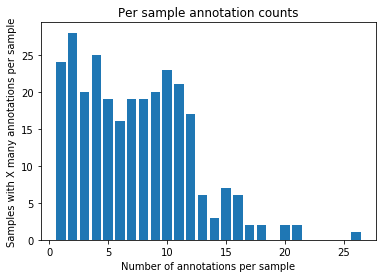

In [11]:
plot_annotation_count(df)

## Calculate perception uncertainty

### My Method

In [37]:
def calculatePU(labels, classes):
    # Map given labels to indices between 0 - len(classes)
    mapping = {cl: index for index, cl in enumerate(classes)}
    all_labels = [mapping[x] for x in labels]
    
    # calculate counts of each label
    class_occurence_counts = np.bincount(all_labels, minlength=len(classes))
    
    # normalize the counts array by dividing by the max value and then deleting it from the array
    max_count_index = np.argmax(class_occurence_counts)
    coc_normalized = class_occurence_counts / class_occurence_counts[max_count_index]
    coc_normalized = np.delete(coc_normalized, max_count_index)
    
    # mean of coc_normalized would have perception uncertainty: 0 for NO perception uncertainty - 1 for Max perception uncertainty (all labels are equally likely)
    return np.mean(coc_normalized)

In [ ]:
dfPerception = df.groupby(['Comment_number','Sentence_number']) \
                 .agg(Sentence=('Sentence', 'first'),
                      Sentiment_PU=('Sentiment', lambda x: calculatePU(x,sentiments)),
                      Coarse_Entity_PU=('Coarse_Entity', lambda x: calculatePU(x,entities_coarse)),
                      Coarse_Attribute_PU=('Coarse_Attribute', lambda x: calculatePU(x,attributes_coarse)),
                      Coarse_Triplet_PU=('Coarse_Triplet', lambda x: calculatePU(x,triplets_coarse)),
                      Fine_Entity_PU=('Entity', lambda x: calculatePU(x,entities_fine)),
                      Fine_Attribute_PU=('Attribute', lambda x: calculatePU(x,attribute_fine)),
                      Fine_Triplet_PU=('Fine_Triplet', lambda x: calculatePU(x,triplets_fine))) \
                 .reset_index()

### Normalized Information Entropy

In [23]:
max_annotations = df.groupby(['Comment_number','Sentence_number']).agg('count')['Attribute'].max()
max_annotations_with_enough_samples = 16

# used for confidence_interval
b = 1 + np.divide(-1.45, 1 + np.power(np.divide(max_annotations_with_enough_samples, 3.03), 1.06))

In [60]:
def calculate_NIEntropy(labels, max_annotations_with_enough_samples):
    total_annotations = len(labels)
    if total_annotations == 1:
        return -1  # For samples that have only one label, will be removed later
    
    # This change made for N = max number of annotations for any sample
    # total_annotations = max_annotations
    """
    if total_annotations > max_annotations_with_enough_samples:
        labels = np.random.choice(labels, size=max_annotations_with_enough_samples, replace=False)
        total_annotations = max_annotations_with_enough_samples
    """
    
    # Get occurence count for each label
    unique_labels, occur_count = np.unique(labels, return_counts=True)
    
    # Get P-Values
    p_values = np.divide(occur_count, total_annotations)
    
    # Calculate log of base N using simple log method, where N is total number of annotations
    log_p_base_n = np.log(p_values) / np.log(total_annotations)
    
    # Sum over all annotations to calculate NIE
    normalized_information_entropy = -1 * np.sum(np.multiply(p_values, log_p_base_n))
    return normalized_information_entropy

In [61]:
def calculate_conf_inter(total_annotations, b):
    return 0.5 * np.power(b, total_annotations)

In [62]:
dfPerception = df.groupby(['Comment_number','Sentence_number']) \
                 .agg(Sentence=('Sentence', 'first'),
                      Annotation_Count=('Author_ID', 'count'),
                      Confidence_Interval=('Author_name', lambda x: calculate_conf_inter(len(x), b)),
                      Sentiment_PU=('Sentiment', lambda x: calculate_NIEntropy(x, max_annotations_with_enough_samples)),
                      Coarse_Entity_PU=('Coarse_Entity', lambda x: calculate_NIEntropy(x, max_annotations_with_enough_samples)),
                      Coarse_Attribute_PU=('Coarse_Attribute', lambda x: calculate_NIEntropy(x, max_annotations_with_enough_samples)),
                      Coarse_Triplet_PU=('Coarse_Triplet', lambda x: calculate_NIEntropy(x, max_annotations_with_enough_samples)),
                      Fine_Entity_PU=('Entity', lambda x: calculate_NIEntropy(x, max_annotations_with_enough_samples)),
                      Fine_Attribute_PU=('Attribute', lambda x: calculate_NIEntropy(x, max_annotations_with_enough_samples)),
                      Fine_Triplet_PU=('Fine_Triplet', lambda x: calculate_NIEntropy(x, max_annotations_with_enough_samples))) \
                 .reset_index()

### Perception Uncertainty based on Majority class count

In [76]:
def calculate_PU_Majority(labels):
    total_annotations = len(labels)
    if total_annotations == 1:
        return -1  # For samples that have only one label, will be removed later
    
    majority_class_annotation_count = max(Counter(labels).values())
    return 1 - (majority_class_annotation_count / total_annotations)

In [77]:
dfPerception = df.groupby(['Comment_number','Sentence_number']) \
                 .agg(Sentence=('Sentence', 'first'),
                      Annotation_Count=('Author_ID', 'count'),
                      Sentiment_PU=('Sentiment', lambda x: calculate_PU_Majority(x)),
                      Coarse_Entity_PU=('Coarse_Entity', lambda x: calculate_PU_Majority(x)),
                      Coarse_Attribute_PU=('Coarse_Attribute', lambda x: calculate_PU_Majority(x)),
                      Coarse_Triplet_PU=('Coarse_Triplet', lambda x: calculate_PU_Majority(x)),
                      Fine_Entity_PU=('Entity', lambda x: calculate_PU_Majority(x)),
                      Fine_Attribute_PU=('Attribute', lambda x: calculate_PU_Majority(x)),
                      Fine_Triplet_PU=('Fine_Triplet', lambda x: calculate_PU_Majority(x))) \
                 .reset_index()

In [78]:
dfPerception.tail()

,Comment_number,Sentence_number,Sentence,Annotation_Count,Sentiment_PU,Coarse_Entity_PU,Coarse_Attribute_PU,Coarse_Triplet_PU,Fine_Entity_PU,Fine_Attribute_PU,Fine_Triplet_PU
277,502,2,"""""Does """"""""93% more energy efficient"""""""" actua...",6,0.333333,0.50,0.166667,0.666667,0.500,0.5000,0.833333
278,502,3,that in some cases organic farming was actuall...,10,0.300000,0.00,0.300000,0.600000,0.200,0.6000,0.700000
279,507,2,I'm not a big fan of the monocultures for exac...,1,-1.000000,-1.00,-1.000000,-1.000000,-1.000,-1.0000,-1.000000
280,507,3,"""""Commercial """"""""organic"""""""" is deeply problem...",16,0.562500,0.25,0.062500,0.562500,0.500,0.0625,0.750000
281,510,1,If there is a considerable decrease in input c...,8,0.500000,0.00,0.000000,0.500000,0.375,0.0000,0.625000


In [79]:
# Remove samples with only 1 label
dfPerception = dfPerception[dfPerception.Sentiment_PU != -1]

In [80]:
dfPerception.tail()

,Comment_number,Sentence_number,Sentence,Annotation_Count,Sentiment_PU,Coarse_Entity_PU,Coarse_Attribute_PU,Coarse_Triplet_PU,Fine_Entity_PU,Fine_Attribute_PU,Fine_Triplet_PU
276,502,1,"""""The abstract of the article says"","" """"""""Howe...",11,0.454545,0.454545,0.000000,0.545455,0.545455,0.363636,0.727273
277,502,2,"""""Does """"""""93% more energy efficient"""""""" actua...",6,0.333333,0.500000,0.166667,0.666667,0.500000,0.500000,0.833333
278,502,3,that in some cases organic farming was actuall...,10,0.300000,0.000000,0.300000,0.600000,0.200000,0.600000,0.700000
280,507,3,"""""Commercial """"""""organic"""""""" is deeply problem...",16,0.562500,0.250000,0.062500,0.562500,0.500000,0.062500,0.750000
281,510,1,If there is a considerable decrease in input c...,8,0.500000,0.000000,0.000000,0.500000,0.375000,0.000000,0.625000


In [83]:
filePath = './data/jointly_annotated_PU_NIE_4_majority_class.csv'
dfPerception.to_csv(filePath, sep='|', encoding='utf-8',index=False)

## Data exploration

In [2]:
filePath = './data/jointly_annotated_PU_NIE_simple_NIE.csv'
dfPerception = pd.read_csv(filePath, sep='|')

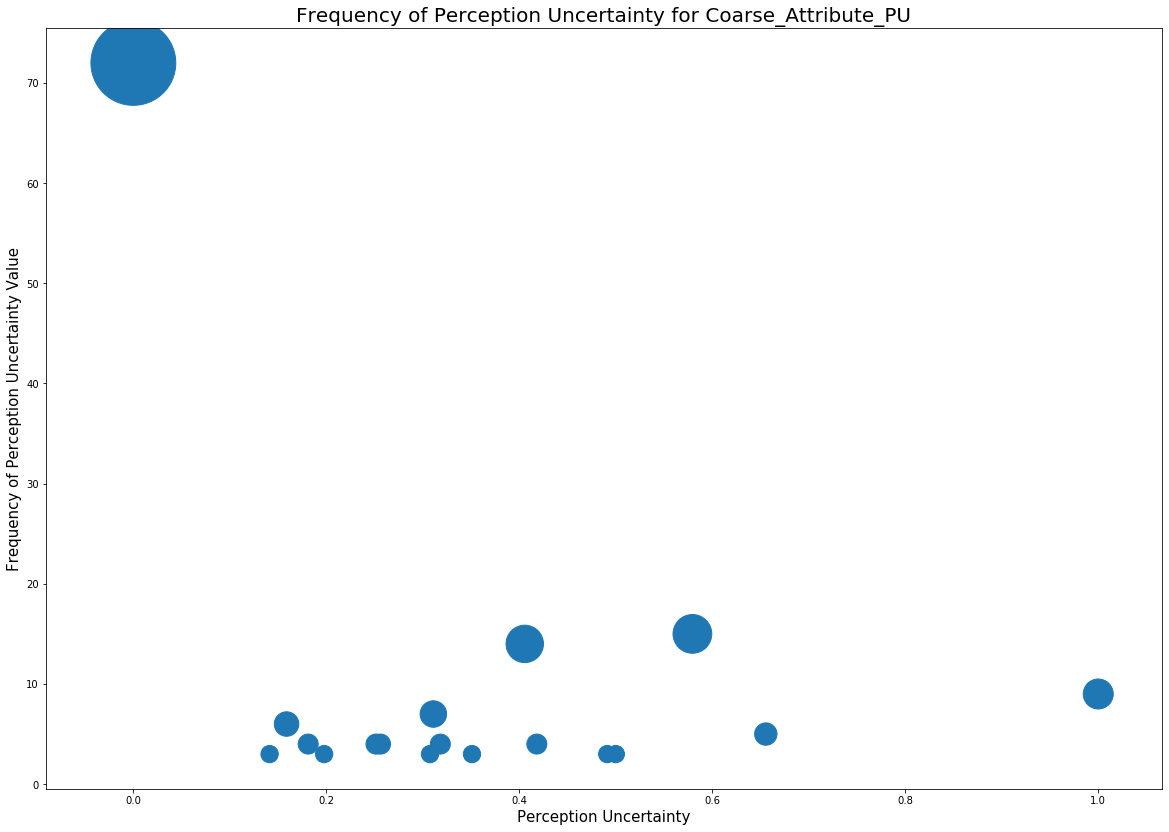

In [5]:
column = 'Coarse_Attribute_PU'
series = dfPerception[column].value_counts().to_dict()
series = sorted(series.items(), key=operator.itemgetter(0))
series = {elem[0]: elem[1] for elem in series if elem[1]>2}

plt.figure(figsize=(20,14))
keys = list(series.keys())
vals = list(series.values())
#size = [dfPerception[dfPerception[column]==key]['Annotation_Count'].mean() for key in keys]
plt.scatter(keys, vals, s=np.multiply(vals,100))
plt.xlabel('Perception Uncertainty', fontsize=15)
plt.ylabel('Frequency of Perception Uncertainty Value', fontsize=15)
plt.title('Frequency of Perception Uncertainty for '+column, fontsize=20)
plt.savefig('Frequency-PU-Attribute.pdf')
plt.show()

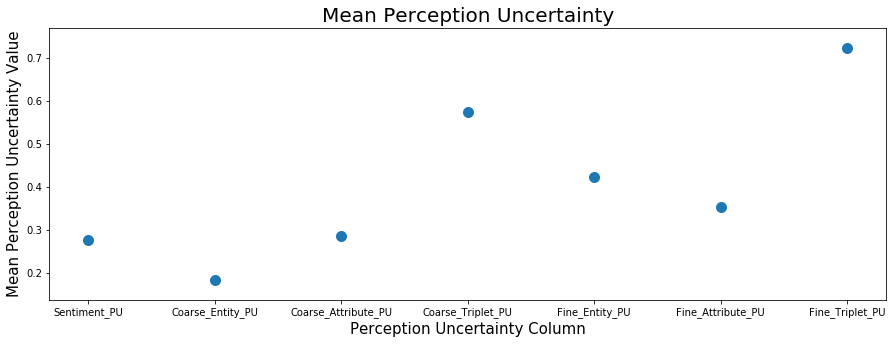

In [6]:
all_PUs = ['Sentiment_PU', 'Coarse_Entity_PU', 'Coarse_Attribute_PU', 'Coarse_Triplet_PU', 'Fine_Entity_PU', 'Fine_Attribute_PU', 'Fine_Triplet_PU']
mean_vals = [dfPerception[pu].mean() for pu in all_PUs]
plt.figure(figsize=(15,5))
plt.scatter(all_PUs, mean_vals, s=100)
plt.xlabel('Perception Uncertainty Column', fontsize=15)
plt.ylabel('Mean Perception Uncertainty Value', fontsize=15)
plt.title('Mean Perception Uncertainty', fontsize=20)
plt.savefig('Mean-Perception-Uncertainty.pdf')
plt.show()